In [1]:
import itertools
import numpy as np
from functools import partial
from oscar import (
    CustomExecutor,
    QiskitOptimizer,
    plot_2d_landscape,
    ScikitQuantOptimizer,
    PDFOOptimizer,
)
from qiskit.algorithms.optimizers import COBYLA
from math import pi
from run_landscape import evaluate_energy
import matplotlib.pyplot as plt
import pickle


def sample_energy(params, landscape, landscape_std, shots, sample_seed=42):
    energy = landscape.interpolator(params)[0]
    if shots is None:
        return energy
    energy_std = landscape_std.interpolator(params)[0] / np.sqrt(shots)
    return np.random.default_rng(sample_seed).normal(energy, energy_std)

p=1 n=14 seed=0 maxfev=4 shots=2500
Grid minima:  [-1.1375   1.04375] 0.07403812812560229


/home/hao/.pyenv/versions/3.10.11/envs/shot-frugal3.10/lib/python3.10/site-packages/pdfo/_dependencies.py:1809: Warning: pdfo: invalid maxfev; uobyqa requires maxfev > (n+1)*(n+2)/2; it is set to (n+1)*(n+2)/2+1.
  warnings.warn(warn_message, Warning)


Total time: 0.004621744155883789
Optimal parameters reported:  [-1.13254974  1.05054392]
Optimal value reported:  0.07504588883852993
Number of evaluations:  7


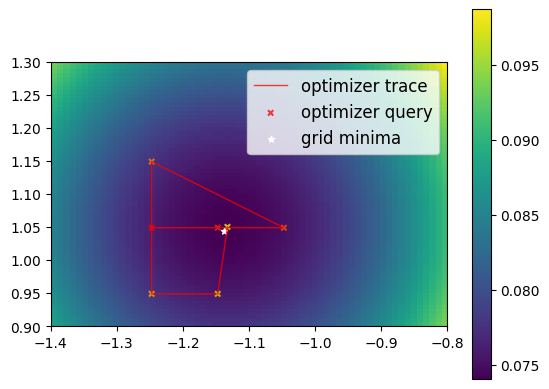

p=1 n=14 seed=0 maxfev=5 shots=2000
Grid minima:  [-1.1375   1.04375] 0.07403812812560229
Total time: 0.0063059329986572266
Optimal parameters reported:  [-1.1325444   1.05054415]
Optimal value reported:  0.07516467211317464
Number of evaluations:  7


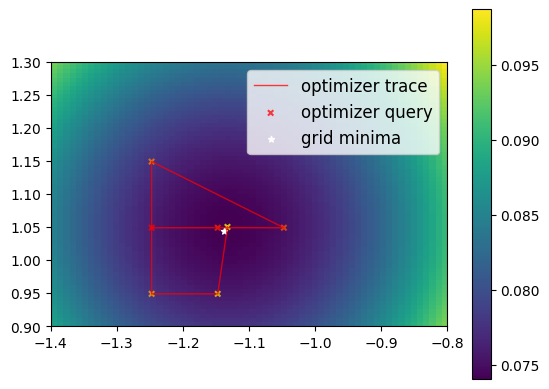

p=1 n=14 seed=0 maxfev=6 shots=1666
Grid minima:  [-1.1375   1.04375] 0.07403812812560229
Total time: 0.0035796165466308594
Optimal parameters reported:  [-1.13253956  1.05054436]
Optimal value reported:  0.0752723069649895
Number of evaluations:  7


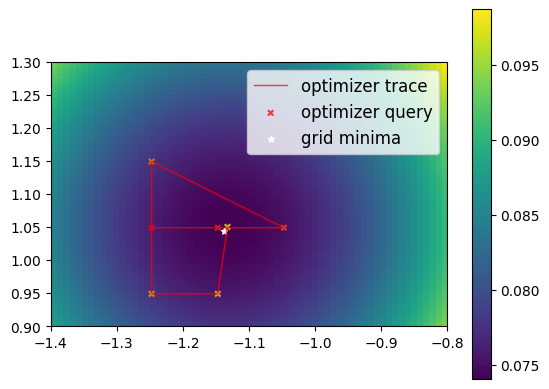

p=1 n=14 seed=0 maxfev=7 shots=1428
Grid minima:  [-1.1375   1.04375] 0.07403812812560229
Total time: 0.003422260284423828
Optimal parameters reported:  [-1.13253513  1.05054456]
Optimal value reported:  0.07537108041890873
Number of evaluations:  7


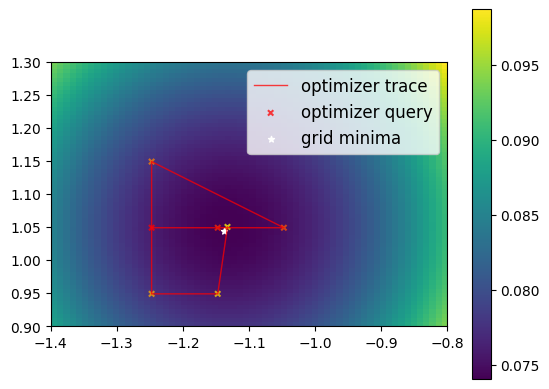

In [5]:
depth_pool = [1]
qubit_pool = [14]
seed_pool = [0]
maxfev_pool = range(4, 8)
resolutions = [64, 64]
bounds = [(-1.4, -0.8), (0.9, 1.3)]
# resolutions = [64, 64]
# bounds = [(-pi / 4, pi / 4), (-pi / 2, pi / 2)]
sample_seed = 42
method = "uobyqa"
method_pool = ["uobyqa", "newuoa", "bobyqa", "lincoa", "cobyla", "imfil", "snobfit"]
budget = 10000
initial_point = [-1.24727193, 1.04931211]
fontsize = 12

for p, n, seed, maxfev in itertools.product(depth_pool, qubit_pool, seed_pool, maxfev_pool):
    shots = None if maxfev is None else budget // maxfev
    print(f"{p=} {n=} {seed=} {maxfev=} {shots=}")
    filename = f"data/landscapes/{p=}/{n=}/{p=}-{n=}-{seed=}-{bounds}-{resolutions}"
    landscape = np.load(filename + ".pckl", allow_pickle=True)
    print("Grid minima: ", landscape.optimal_params.flatten(), landscape.optimal_value)
    landscape_std = np.load(filename + "-std.pckl", allow_pickle=True)
    itpl_executor = CustomExecutor(
        partial(
            sample_energy,
            landscape=landscape,
            landscape_std=landscape_std,
            shots=shots,
            sample_seed=sample_seed,
        )
    )
    for itpl_executor in [
            itpl_executor, 
            # CustomExecutor(partial(evaluate_energy, p=p, n=n, problem_seed=seed, shots=shots, sample_seed=sample_seed))
        ]:
        if method in ["imfil", "snobfit"]:
            trace, _ = ScikitQuantOptimizer(method, maxfev).run(
                itpl_executor, initial_point=initial_point, bounds=bounds
            )
        elif method in ["uobyqa", "newuoa"]:
            trace, _ = PDFOOptimizer(method, maxfev).run(
                itpl_executor, initial_point=initial_point, rhobeg=0.1
            )
        else:
            trace, _ = PDFOOptimizer(method, maxfev).run(
                itpl_executor, initial_point=initial_point, bounds=bounds, rhobeg=0.1
            )
        print(f"Total time: {sum(trace.time_trace)}")
        print("Optimal parameters reported: ", trace.optimal_params)
        print("Corresponding optimal value: ", itpl_executor.run(trace.optimal_params))
        print("Number of evaluations: ", trace.num_fun_evals)
        figure = plot_2d_landscape(landscape, trace, "auto", show=False)
        # figure.axes[1].tick_params(labelsize=fontsize)
        # plt.xticks(fontsize=fontsize)
        # plt.yticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize)
        # plt.xlim(-1, 0)
        # plt.ylim(0.7, 1.3)
        plt.show()

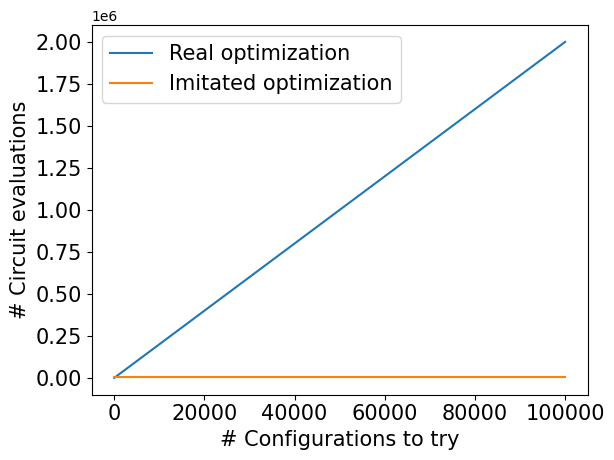

In [5]:
x = np.linspace(0, 100000, 100)
fontsize = 15
plt.figure()
plt.plot(x, 20 * x, label="Real optimization")
plt.plot(x, np.array([2**12] * len(x)), label="Imitated optimization")
plt.xlabel("# Configurations to try", fontsize=fontsize)
plt.ylabel("# Circuit evaluations", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [6]:
depth_pool = [1]
qubit_pool = [14, 16, 18]
seed_pool = list(range(10))
# shot_pool = range(100, 1601, 500)
maxfev_pool = list(range(7, 21)) + [25, 33, 50, 66, 100]
resolutions = [128, 32]
bounds = [(-2.2, -0.6), (0.9, 1.3)]
initial_point = [-1.24727193, 1.04931211]
sample_seed = 42
method_pool = ["uobyqa", "newuoa", "bobyqa", "lincoa", "cobyla"]#, "imfil", "snobfit"]
budget = 10000
rhobeg_pool = np.linspace(0.001, 0.01, 10).tolist() + np.linspace(0.02, 0.1, 9).tolist()


configs = []
for method, maxfev, rhobeg in itertools.product(method_pool, maxfev_pool, rhobeg_pool):
    shots = budget // maxfev
    if method in ["snobfit", "imfil"] and rhobeg != rhobeg_pool[0]:
        continue
    # elif method == "":
    configs.append((method, maxfev, shots, rhobeg))
mean_ar = np.zeros(len(configs), dtype=float)
solved_ratio = np.zeros(len(configs), dtype=float)
num_instances = len(depth_pool) * len(qubit_pool) * len(seed_pool)
print(f"Trying {len(configs)} configs on {num_instances} instances...")

for p, n, seed in itertools.product(depth_pool, qubit_pool, seed_pool):
    print(f"Landscape {p=} {n=} {seed=}")
    filename = f"data/landscapes/{p=}/{n=}/{p=}-{n=}-{seed=}-{bounds}-{resolutions}"
    landscape = np.load(filename + ".pckl", allow_pickle=True)
    print("Grid minima: ", landscape.optimal_params.flatten(), landscape.optimal_value)
    landscape_std = np.load(filename + "-std.pckl", allow_pickle=True)
    po_problem = pickle.load(open(f"data/random/po_problem_rule_{n}_{n//2}_0.5_seed{seed}.pckl", "rb"))
    min_constrained = po_problem["feasible_min"]
    max_constrained = po_problem["feasible_max"]
    # true_executor = CustomExecutor(
    #     partial(evaluate_energy, p=p, n=n, problem_seed=seed, shots=None, sample_seed=sample_seed)
    # )
    true_executor = CustomExecutor(
        partial(
            sample_energy,
            landscape=landscape,
            landscape_std=landscape_std,
            shots=None,
            sample_seed=sample_seed,
        )
    )

    energies, solved_counts = [], []
    for method, maxfev, shots, rhobeg in configs:
        itpl_executor = CustomExecutor(
            partial(
                sample_energy,
                landscape=landscape,
                landscape_std=landscape_std,
                shots=shots,
                sample_seed=sample_seed,
            )
        )
        if method in ["imfil", "snobfit"]:
            trace, _ = ScikitQuantOptimizer(method, maxfev).run(
                itpl_executor, initial_point=initial_point, bounds=bounds
            )
        elif method in ["uobyqa", "newuoa"]:
            trace, _ = PDFOOptimizer(method, maxfev).run(
                itpl_executor, initial_point=initial_point, rhobeg=rhobeg
            )
        else:
            trace, _ = PDFOOptimizer(method, maxfev).run(
                itpl_executor, initial_point=initial_point, bounds=bounds, rhobeg=rhobeg
            )
        energies.append(true_executor.run(trace.optimal_params))
        solved_counts.append(int(energies[-1] < landscape.optimal_value))
    mean_ar = mean_ar + (np.array(energies) - max_constrained) / (min_constrained - max_constrained)
    solved_ratio += solved_counts

mean_ar /= num_instances
solved_ratio /= num_instances
for i in np.argsort(mean_ar)[-1:-500:-1]:
    print(mean_ar[i], configs[i])

Trying 1805 configs on 30 landscapes...
Landscape p=1 n=14 seed=0
Grid minima:  [-1.1375  1.05  ] 0.07404427012749953


/home/hao/.pyenv/versions/3.10.11/envs/shot-frugal3.10/lib/python3.10/site-packages/pdfo/_dependencies.py:1678: Warning: pdfo: unknown option(s): scale; they are ignored.
  warnings.warn(warn_message, Warning)


Landscape p=1 n=14 seed=1
Grid minima:  [-1.575  1.   ] 0.01805364419413583
Landscape p=1 n=14 seed=2
Grid minima:  [-0.975   1.0375] 0.016837202585963017
Landscape p=1 n=14 seed=3
Grid minima:  [-0.8875  1.    ] 0.0030535975659420384
Landscape p=1 n=14 seed=4
Grid minima:  [-1.025   1.0625] -0.023596124904355434
Landscape p=1 n=14 seed=5
Grid minima:  [-1.2625  1.0375] 0.03600037437007174
Landscape p=1 n=14 seed=6
Grid minima:  [-1.1875  1.025 ] -0.015965250446928328
Landscape p=1 n=14 seed=7
Grid minima:  [-0.8625  1.0625] -0.008389412623861869
Landscape p=1 n=14 seed=8
Grid minima:  [-1.075   1.1125] -0.00428625318950715
Landscape p=1 n=14 seed=9
Grid minima:  [-1.2875  1.15  ] -0.03888272745385136
Landscape p=1 n=16 seed=0
Grid minima:  [-1.05  1.05] 0.06899150935358644
Landscape p=1 n=16 seed=1
Grid minima:  [-1.525   0.9875] 0.014763406524827709
Landscape p=1 n=16 seed=2
Grid minima:  [-1.175   1.0625] 0.03124085288112971
Landscape p=1 n=16 seed=3
Grid minima:  [-0.8375  0.9875] 

KeyboardInterrupt: 

In [9]:
for i in np.argsort(mean_ar)[:100]:
    print(mean_ar[i], configs[i])

-9.004362106265958 ('uobyqa', 50, 200, 0.05)
-9.004357712783552 ('newuoa', 66, 151, 0.04)
-9.004357101505782 ('newuoa', 50, 200, 0.007)
-9.004355982163336 ('uobyqa', 50, 200, 0.005)
-9.004354759534387 ('newuoa', 50, 200, 0.06)
-9.004352042216594 ('uobyqa', 100, 100, 0.006)
-9.00435188226656 ('uobyqa', 50, 200, 0.007)
-9.004350795297551 ('uobyqa', 50, 200, 0.07)
-9.004350636914381 ('newuoa', 33, 303, 0.05)
-9.004350632490635 ('uobyqa', 50, 200, 0.002)
-9.004349293263665 ('uobyqa', 66, 151, 0.05)
-9.004348944712866 ('newuoa', 100, 100, 0.005)
-9.004348654264756 ('uobyqa', 50, 200, 0.006)
-9.00434789678285 ('uobyqa', 50, 200, 0.001)
-9.00434758241178 ('uobyqa', 66, 151, 0.1)
-9.004347075975833 ('uobyqa', 50, 200, 0.04)
-9.004346510610217 ('uobyqa', 66, 151, 0.005)
-9.004346273971787 ('uobyqa', 66, 151, 0.003)
-9.004346205841511 ('uobyqa', 33, 303, 0.09000000000000001)
-9.004346119043584 ('uobyqa', 100, 100, 0.05)
-9.004345209060919 ('newuoa', 50, 200, 0.04)
-9.004344377337011 ('uobyqa', 5

In [ ]:
pickle.dump(
    {
        "mean_ar": mean_ar,
        "solved_ratio": solved_ratio,
        "configs": configs,
        "method_pool": method_pool,
        "maxfev_pool": maxfev_pool,
        "rhobeg_pool": rhobeg_pool,
        "depth_pool": depth_pool,
        "qubit_pool": qubit_pool,
        "seed_pool": seed_pool,
        "resolutions": resolutions,
        "bounds": bounds,
        "initial_point": initial_point,
        "sample_seed": sample_seed,
        "budget": budget,
    },
    open(
        f"data/configs/m{len(method_pool)}xf{len(maxfev_pool)}xr{len(rhobeg_pool)}-d{len(depth_pool)}xq{len(qubit_pool)}xs{len(seed_pool)}",
        "wb",
    ),
)